In [2]:
%pip install torch torchvision torchaudio transformers datasets evaluate accelerate peft matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00


# 1. Installing and importing necessary libraries.  

Prior to data processing, the required libraries and dependencies are installed and imported. The process is conducted within a Google Colab environment to leverage GPU acceleration, as the computational requirements for this task are very slow for current device (a standard CPU-only machine).

In [3]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer, default_data_collator
from peft import LoraConfig, get_peft_model, TaskType, IA3Config
import evaluate
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import collections
import time

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (f'Device: {device}')

Device: cuda


# 2. Loading the dataset
The Stanford Question Answering Dataset (SQuAD) v1 is utilized for this project. SQuAD is a well-established and widely used benchmark for developing and evaluating models on extractive Question Answering tasks. The dataset is sourced from the Hugging Face datasets library.



In [5]:
dataset = load_dataset("squad")
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})


In [6]:
# look at one example
example = dataset["train"][0]
print("Example question:", example["question"])
print("Context snippet:", example["context"][:200], "...")
print("Answer:", example["answers"])

Example question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Context snippet: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper sta ...
Answer: {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}


# 3. Initialize tokenizer

DistilBERT was selected for this task due to its highly efficient architecture. As a smaller, distilled version of the BERT model, it provides significantly faster inference and requires fewer computational resources for training. Crucially, these advantages in efficiency are achieved while maintaining performance levels that are comparable to its larger, more resource-intensive counterparts.

In [7]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)
# model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased").to(device)

tokens = tokenizer(example["question"], example["context"])
print(tokens.keys())
print("Number of tokens:", len(tokens["input_ids"]))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

KeysView({'input_ids': [101, 2000, 3183, 2106, 1996, 6261, 2984, 9382, 3711, 1999, 8517, 1999, 10223, 26371, 2605, 1029, 102, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, 23052, 2012, 10223, 26371, 1010, 2605, 2073, 1996, 6261, 2984, 22353, 2135, 2596, 2000, 3002, 16595, 9648, 4674, 2061, 12083, 9711, 2271, 1999, 8517, 1012, 2012, 1996, 2203, 1997, 1996, 2364, 3298, 1006, 1998, 1999, 1037, 3622, 2240, 2008, 8539, 2083, 1017, 11342, 1998,

In [8]:
def prepare_train_features(examples):
    #tokenize question, answer pair
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=256,
        stride=64,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples["offset_mapping"]

    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []
    tokenized_examples["example_id"] = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_examples["input_ids"][i]
        sequence_ids = tokenized_examples.sequence_ids(i)
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        tokenized_examples["example_id"].append(examples["id"][sample_index])

        start_char = answers["answer_start"][0]
        end_char = start_char + len(answers["text"][0])
        token_start_index = 0
        while sequence_ids[token_start_index] != 1: token_start_index += 1
        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1: token_end_index -= 1
        if offsets[token_start_index][0] > start_char or offsets[token_end_index][1] < end_char:
            tokenized_examples["start_positions"].append(0)
            tokenized_examples["end_positions"].append(0)
        else:
            while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char: token_start_index += 1
            start_pos = token_start_index - 1
            while token_end_index >= 0 and offsets[token_end_index][1] >= end_char: token_end_index -= 1
            end_pos = token_end_index + 1
            tokenized_examples["start_positions"].append(start_pos)
            tokenized_examples["end_positions"].append(end_pos)

    return tokenized_examples

In [9]:
train_dataset = dataset["train"].map(
    prepare_train_features,
    batched=True,
    remove_columns=dataset["train"].column_names,
    desc="Tokenizing train set",
)

validation_dataset = dataset["validation"].map(
    prepare_train_features,
    batched=True,
    remove_columns=dataset["validation"].column_names,
    desc="Tokenizing validation set",
)

print(train_dataset)

Tokenizing train set:   0%|          | 0/87599 [00:00<?, ? examples/s]

Tokenizing validation set:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'start_positions', 'end_positions', 'example_id'],
    num_rows: 96487
})


In [10]:
sample = train_dataset[0]
print("Input IDs:", sample["input_ids"][:20])
print("Start position:", sample["start_positions"])
print("End position:", sample["end_positions"])

decoded_context = tokenizer.decode(sample["input_ids"])
print("Decoded context snippet:", decoded_context[:300])

Input IDs: [101, 2000, 3183, 2106, 1996, 6261, 2984, 9382, 3711, 1999, 8517, 1999, 10223, 26371, 2605, 1029, 102, 6549, 2135, 1010]
Start position: 130
End position: 137
Decoded context snippet: [CLS] to whom did the virgin mary allegedly appear in 1858 in lourdes france? [SEP] architecturally, the school has a catholic character. atop the main building ' s gold dome is a golden statue of the virgin mary. immediately in front of the main building and facing it, is a copper statue of christ 


# 4. Two finetuned models
This analysis aims to compare the performance of two distinct parameter-efficient fine-tuning (PEFT) methods: Low-Rank Adaptation (LoRA) and Infused Adapter by Inhibiting and Amplifying Inner Activations ((IA)3).

## Hyperparameter tuning (sweep) on two finetuned model.
To determine the optimal training configuration for two distinct parameter-efficient fine-tuning (PEFT) methods, a comparative hyperparameter sweep was performed. The sweep focused specifically on the learning rate, a critical hyperparameter that profoundly influences training stability, convergence speed, and final model performance. To ensure this optimization process was computationally tractable, the sweep was executed on a smaller, representative subset of the dataset.

In [11]:
num_samples_sweep = int(0.1 * len(train_dataset)) # Using 10% of the data
sweep_train_dataset = train_dataset.select(range(num_samples_sweep))
num_samples_eval_sweep = int(0.1 * len(validation_dataset))
sweep_eval_dataset = validation_dataset.select(range(num_samples_eval_sweep))

In [16]:
learning_rates = [5e-5, 3e-5, 1e-5]; results = {}
for lr in learning_rates:
    print(f"\n--- LoRA Sweep: Testing Learning Rate: {lr} ---")
    model_sweep = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased")
    lora_config_sweep = LoraConfig(r=16,
                                   lora_alpha=32,
                                   lora_dropout=0.1,
                                   task_type=TaskType.QUESTION_ANS,
                                   target_modules=["q_lin", "v_lin"])

    lora_model_sweep = get_peft_model(model_sweep, lora_config_sweep).to(device)

    sweep_args = TrainingArguments(output_dir=f"./sweep_lora_lr_{lr}",
                                   eval_strategy="epoch",
                                   learning_rate=lr,
                                   per_device_train_batch_size=8,
                                   num_train_epochs=1,
                                   weight_decay=0.01,
                                   report_to="none")

    sweep_trainer = Trainer(model=lora_model_sweep,
                            args=sweep_args,
                            train_dataset=sweep_train_dataset,
                            eval_dataset=sweep_eval_dataset)
    sweep_trainer.train()
    eval_metrics = sweep_trainer.evaluate()
    results[lr] = eval_metrics["eval_loss"]
best_lr = min(results, key=results.get)

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA Sweep: Testing Learning Rate: 5e-05 ---


Epoch,Training Loss,Validation Loss
1,3.618800,3.555562


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA Sweep: Testing Learning Rate: 3e-05 ---


Epoch,Training Loss,Validation Loss
1,3.873200,3.761619


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA Sweep: Testing Learning Rate: 1e-05 ---


Epoch,Training Loss,Validation Loss
1,5.187300,4.966222


In [21]:
learning_rates = [5e-5, 3e-5, 1e-5]
ia3_results = {}
for lr in learning_rates:
    print(f"\n--- (IA)3 Sweep: Testing LR: {lr} ---")
    model_sweep_ia3 = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased")
    ia3_config_sweep = IA3Config(
        task_type=TaskType.QUESTION_ANS,
        target_modules=["q_lin", "k_lin", "v_lin", "out_lin", "lin1", "lin2"],
        feedforward_modules=["lin1", "lin2"],
    )
    ia3_model_sweep = get_peft_model(model_sweep_ia3, ia3_config_sweep).to(device)
    sweep_args_ia3 = TrainingArguments(output_dir=f"./sweep_ia3_lr_{lr}",
                                        eval_strategy="epoch",
                                        learning_rate=lr,
                                        per_device_train_batch_size=8,
                                        num_train_epochs=1,
                                        weight_decay=0.01,
                                       report_to="none")

    sweep_trainer_ia3 = Trainer(model=ia3_model_sweep,
                                args=sweep_args_ia3,
                                train_dataset=sweep_train_dataset,
                                eval_dataset=sweep_eval_dataset)

    sweep_trainer_ia3.train()
    eval_metrics_ia3 = sweep_trainer_ia3.evaluate()
    ia3_results[lr] = eval_metrics_ia3["eval_loss"]

best_lr_ia3 = min(ia3_results, key=ia3_results.get)


--- (IA)3 Sweep: Testing LR: 5e-05 ---


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,4.964900,4.802255


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- (IA)3 Sweep: Testing LR: 3e-05 ---


Epoch,Training Loss,Validation Loss
1,5.228000,5.143240


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- (IA)3 Sweep: Testing LR: 1e-05 ---


Epoch,Training Loss,Validation Loss
1,5.443000,5.422534


## Final training on two finetuned model.
Following the hyperparameter sweep, the LoRA and ((IA)3)models were trained on the full dataset using their respective optimal learning rates. Throughout this final training process, the training and validation loss curves were generated to monitor convergence, diagnose stability, and visually analyze the learning dynamics of each parameter-efficient fine-tuning method.

In [12]:
def plot_loss_curves(log_history, save_path, title):
    """
    Plots training and validation loss curves from the Trainer's log history.
    """
    # Separate training and validation logs
    train_logs = [log for log in log_history if 'loss' in log]
    val_logs = [log for log in log_history if 'eval_loss' in log]

    # Extract epochs and loss values
    train_epochs = [log['epoch'] for log in train_logs]
    train_losses = [log['loss'] for log in train_logs]
    val_epochs = [log['epoch'] for log in val_logs]
    val_losses = [log['eval_loss'] for log in val_logs]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(train_epochs, train_losses, label='Training Loss')
    plt.plot(val_epochs, val_losses, label='Validation Loss', marker='o')

    # Add titles and labels
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Save the plot to a file
    plt.savefig(save_path)
    print(f"Plot saved to {save_path}")

    # Show the plot
    plt.show()

In [18]:
final_model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased")
final_lora_config = LoraConfig(r=16, lora_alpha=32, lora_dropout=0.1, task_type=TaskType.QUESTION_ANS, target_modules=["q_lin", "v_lin"])
final_lora_model = get_peft_model(final_model, final_lora_config).to(device)
final_lora_model.print_trainable_parameters()

final_training_args = TrainingArguments(
    output_dir="./results_lora_final",
    eval_strategy="epoch",
    learning_rate=best_lr,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_steps=500,
    report_to="none"
)

final_trainer_lora = Trainer(
    model=final_lora_model,
    args=final_training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)

# Start final training
train_start_time = time.time()
train_result = final_trainer_lora.train()
train_end_time = time.time()

total_train_time_seconds = train_end_time - train_start_time
print(f"\nTotal Training Time: {total_train_time_seconds / 3600:.2f} hours")

#Colab runtime got disconnected which explains the two tables (ignore the first table)

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 296,450 || all params: 66,660,868 || trainable%: 0.4447


Epoch,Training Loss,Validation Loss
1,2.009000,1.774911
2,1.671500,1.524914


Epoch,Training Loss,Validation Loss
1,2.009000,1.774911
2,1.671500,1.524914
3,1.569800,1.470210



Total Training Time: 1.51 hours


Plot saved to LoRA_Fine_Tuning_Loss_3_Epochs.png


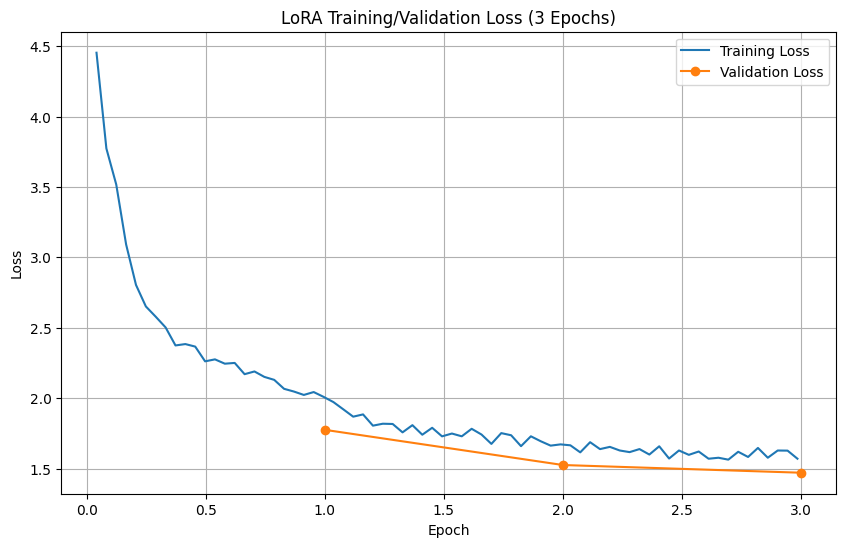

In [19]:
# Plot the loss curves
plot_loss_curves(
    final_trainer_lora.state.log_history,
    "LoRA_Fine_Tuning_Loss_3_Epochs.png",
    "LoRA Training/Validation Loss (3 Epochs)"
)

In [22]:
final_model_ia3 = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased")

final_ia3_config = IA3Config(
    task_type=TaskType.QUESTION_ANS,
    target_modules=["q_lin", "k_lin", "v_lin", "out_lin", "lin1", "lin2"],
    feedforward_modules=["lin1", "lin2"],
)
final_ia3_model = get_peft_model(final_model_ia3, final_ia3_config).to(device)

print("Trainable parameters for final (IA)3 model:")
final_ia3_model.print_trainable_parameters()

final_training_args_ia3 = TrainingArguments(
    output_dir="./results_ia3_final", eval_strategy="epoch", learning_rate=best_lr_ia3,
    per_device_train_batch_size=8, per_device_eval_batch_size=8, num_train_epochs=3,
    weight_decay=0.01, save_strategy="epoch", logging_steps=500, report_to="none"
)
final_trainer_ia3 = Trainer(model=final_ia3_model,
                            args=final_training_args_ia3,
                            train_dataset=train_dataset,
                            eval_dataset=validation_dataset,
                            )


train_start_time_ia3 = time.time()
train_result_ia3 = final_trainer_ia3.train()
train_end_time_ia3 = time.time()
total_train_time_seconds_ia3 = train_end_time_ia3 - train_start_time_ia3
print(f"\nTotal (IA)3 Training Time: {total_train_time_seconds_ia3 / 3600:.2f} hours")

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters for final (IA)3 model:
trainable params: 43,010 || all params: 66,407,428 || trainable%: 0.0648


Epoch,Training Loss,Validation Loss
1,3.284600,3.165853
2,2.841400,2.710039
3,2.744700,2.609799



Total (IA)3 Training Time: 1.54 hours


Plot saved to IA3_Fine_Tuning_Loss_3_Epochs.png


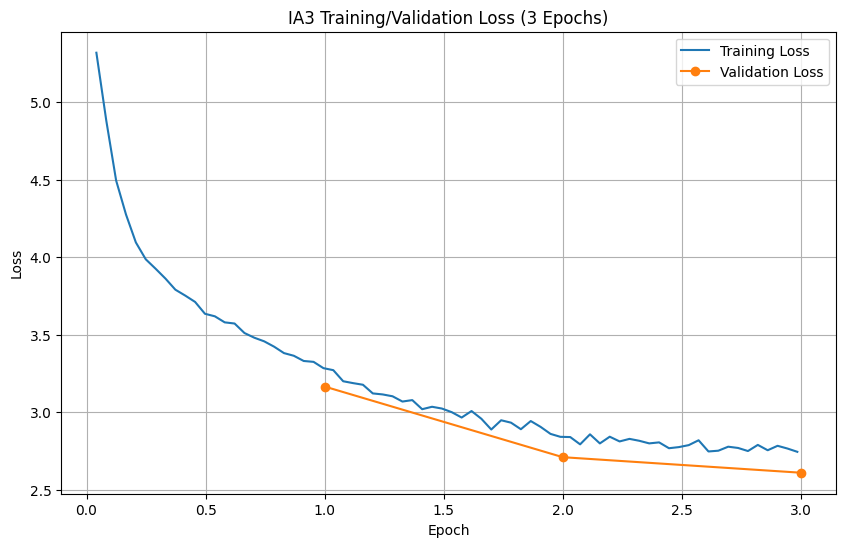

In [23]:
plot_loss_curves(
    final_trainer_ia3.state.log_history,
    "IA3_Fine_Tuning_Loss_3_Epochs.png",
    "IA3 Training/Validation Loss (3 Epochs)"
)

## Evaluation on two finetuned model.
The performance of the final LoRA and ((IA)3) fine-tuned models was assessed through a comprehensive evaluation process. Standard quantitative metrics for this Question Answering task, namely the F1-Score and Exact Match (EM) score, were calculated on the test dataset. To supplement these metrics and probe the models' practical reasoning abilities, a qualitative analysis was also conducted using a curated set of custom examples designed to test performance on challenging or nuanced queries.


In [24]:
def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size=20, max_answer_length=30):
    all_start_logits, all_end_logits = raw_predictions
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    predictions = collections.OrderedDict()

    print("Post-processing predictions...")
    for example_index, example in enumerate(tqdm(examples)):
        feature_indices = features_per_example[example_index]
        min_null_score = None
        valid_answers = []
        context = example["context"]
        for feature_index in feature_indices:
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            offset_mapping = features[feature_index]["offset_mapping"]
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {"score": start_logits[start_index] + end_logits[end_index], "text": context[start_char:end_char]}
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            best_answer = {"text": "", "score": 0.0}

        predictions[example["id"]] = best_answer["text"]

    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in predictions.items()]
    references = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return formatted_predictions, references

In [25]:
print("\n--- Calculating Final EM and F1 Scores for LoRA Model ---")

squad_metric = evaluate.load("squad")

raw_predictions = final_trainer_lora.predict(validation_dataset)

final_predictions, final_references = postprocess_qa_predictions(
    dataset["validation"],
    validation_dataset,
    raw_predictions.predictions
)

metrics = squad_metric.compute(predictions=final_predictions, references=final_references)

print("\nLoRA Model Final Evaluation Report:")
print(f"  Exact Match (EM): {metrics['exact_match']:.4f}")
print(f"  F1 Score: {metrics['f1']:.4f}")


--- Calculating Final EM and F1 Scores for LoRA Model ---


Post-processing predictions...


  0%|          | 0/10570 [00:00<?, ?it/s]


LoRA Model Final Evaluation Report:
  Exact Match (EM): 62.3841
  F1 Score: 72.8802


In [26]:
print("\n--- Calculating Final EM and F1 Scores for (IA)3 Model ---")

squad_metric = evaluate.load("squad")

raw_predictions_ia3 = final_trainer_ia3.predict(validation_dataset)
final_predictions_ia3, final_references_ia3 = postprocess_qa_predictions(
    dataset["validation"],
    validation_dataset,
    raw_predictions_ia3.predictions
)

metrics_ia3 = squad_metric.compute(predictions=final_predictions_ia3, references=final_references_ia3)

print("\n(IA)3 Model Final Evaluation Report:")
print(f"  Exact Match (EM): {metrics_ia3['exact_match']:.4f}")
print(f"  F1 Score: {metrics_ia3['f1']:.4f}")


--- Calculating Final EM and F1 Scores for (IA)3 Model ---


Post-processing predictions...


  0%|          | 0/10570 [00:00<?, ?it/s]


(IA)3 Model Final Evaluation Report:
  Exact Match (EM): 32.3652
  F1 Score: 41.8148


In [27]:
def predict_custom(context, query, model, tokenizer):

    model.eval()
    cpu_device = torch.device("cpu")
    model.to(cpu_device)
    inputs = tokenizer.encode_plus(query, context, return_tensors='pt').to(cpu_device)
    with torch.no_grad():
        outputs = model(**inputs)
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits
    answer_start = torch.argmax(start_logits)
    answer_end = torch.argmax(end_logits) + 1
    answer = tokenizer.convert_tokens_to_string(
        tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end])
    )
    model.to(device)
    return answer

def normalize_text(s):
    import string, re
    def remove_articles(text): return re.sub(r"\b(a|an|the)\b", " ", text)
    def white_space_fix(text): return " ".join(text.split())
    def remove_punc(text): return "".join(ch for ch in text if ch not in exclude)
    exclude = set(string.punctuation)
    return white_space_fix(remove_articles(remove_punc(s.lower())))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    common_tokens = set(pred_tokens) & set(truth_tokens)
    if len(common_tokens) == 0: return 0
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    return 2 * (prec * rec) / (prec + rec)

custom_examples = [
    {
        "context": "Hi! My name is Rachel and I am 21 years old. I am a NUS student and I am currently doing a DSA assignment.",
        "question": "What is Rachel doing?",
        "answer": "A DSA assignment"
    },
    {
        "context": "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and built the tower.",
        "question": "Who designed the Eiffel Tower?",
        "answer": "Gustave Eiffel"
    },

    {
        "context": "Photosynthesis is a process used by plants, algae, and certain bacteria to convert light energy into chemical energy. Through this process, they can later release energy to fuel the organisms' activities. This chemical energy is stored in carbohydrate molecules, such as sugars, which are synthesized from carbon dioxide and water. The process is responsible for producing and maintaining the oxygen content of the Earth's atmosphere. The green pigment responsible for capturing light is called chlorophyll.",
        "question": "What is the name of the green pigment that captures light?",
        "answer": "chlorophyll"
    },

    {
        "context": "n-gram is n consecutive words. There are many forms of n-grams such as Unigram, Bigram, Trigram and Four-grams",
        "question": "What are some forms of n-gramst?",
        "answer": "Unigram, Bigram, Trigram, Four-grams"
    },

    {
        "context": "There are two limitations of fine-tuning. One, it does not address open-ended taks since open-ended tasks have no correct answer. Second, standard language modelling treats all token-level mistakes the same although some mistakes matter much more than others.",
        "question": "How does fine-tuning deal with mistakes?",
        "answer": "Fine-tuning treats all token-level mistakes equally. "
    },
]

In [28]:
all_em_scores_lora = []
all_f1_scores_lora = []

for i, example in enumerate(custom_examples):
    print(f"--- Example {i+1} ---")
    context = example["context"]
    query = example["question"]
    true_answer = example["answer"]

    # Get the model's prediction
    prediction = predict_custom(context, query, final_lora_model, tokenizer)

    # Calculate scores for this example
    em_score = compute_exact_match(prediction, true_answer)
    f1_score = compute_f1(prediction, true_answer)

    # Append scores to our lists
    all_em_scores_lora.append(em_score)
    all_f1_scores_lora.append(f1_score)

    print(f"Question: {query}")
    print(f"Prediction: '{prediction}'")
    print(f"True Answer: '{true_answer}'")
    print(f"EM Score: {em_score}")
    print(f"F1 Score: {f1_score:.4f}")
    print('\n')

average_em_lora = sum(all_em_scores_lora) / len(all_em_scores_lora)
average_f1_lora = sum(all_f1_scores_lora) / len(all_f1_scores_lora)

print(f"Total Examples: {len(custom_examples)}")
print(f"Average Exact Match (EM): {average_em_lora:.4f}")
print(f"Average F1 Score: {average_f1_lora:.4f}")

--- Example 1 ---
Question: What is Rachel doing?
Prediction: 'a dsa assignment'
True Answer: 'A DSA assignment'
EM Score: 1
F1 Score: 1.0000


--- Example 2 ---
Question: Who designed the Eiffel Tower?
Prediction: 'gustave eiffel'
True Answer: 'Gustave Eiffel'
EM Score: 1
F1 Score: 1.0000


--- Example 3 ---
Question: What is the name of the green pigment that captures light?
Prediction: 'chlorophyll'
True Answer: 'chlorophyll'
EM Score: 1
F1 Score: 1.0000


--- Example 4 ---
Question: What are some forms of n-gramst?
Prediction: 'unigram, bigram, trigram'
True Answer: 'Unigram, Bigram, Trigram, Four-grams'
EM Score: 0
F1 Score: 0.8571


--- Example 5 ---
Question: How does fine-tuning deal with mistakes?
Prediction: 'second, standard language modelling'
True Answer: 'Fine-tuning treats all token-level mistakes equally. '
EM Score: 0
F1 Score: 0.0000


Total Examples: 5
Average Exact Match (EM): 0.6000
Average F1 Score: 0.7714


In [29]:
all_em_scores_ia3 = []
all_f1_scores_ia3 = []

for i, example in enumerate(custom_examples):
    print(f"--- Example {i+1} ---")
    context = example["context"]
    query = example["question"]
    true_answer = example["answer"]

    prediction = predict_custom(context, query, final_ia3_model, tokenizer)

    em_score = compute_exact_match(prediction, true_answer)
    f1_score = compute_f1(prediction, true_answer)

    all_em_scores_ia3.append(em_score)
    all_f1_scores_ia3.append(f1_score)

    print(f"Question: {query}")
    print(f"Prediction: '{prediction}'")
    print(f"True Answer: '{true_answer}'")
    print(f"EM Score: {em_score}")
    print(f"F1 Score: {f1_score:.4f}")
    print('\n')

average_em_ia3 = sum(all_em_scores_ia3) / len(all_em_scores_ia3)
average_f1_ia3 = sum(all_f1_scores_ia3) / len(all_f1_scores_ia3)

print(f"Total Examples: {len(custom_examples)}")
print(f"Average Exact Match (EM) for (IA)3: {average_em_ia3:.4f}")
print(f"Average F1 Score for (IA)3: {average_f1_ia3:.4f}")

--- Example 1 ---
Question: What is Rachel doing?
Prediction: '[CLS]'
True Answer: 'A DSA assignment'
EM Score: 0
F1 Score: 0.0000


--- Example 2 ---
Question: Who designed the Eiffel Tower?
Prediction: 'gustave eiffel, whose company'
True Answer: 'Gustave Eiffel'
EM Score: 0
F1 Score: 0.6667


--- Example 3 ---
Question: What is the name of the green pigment that captures light?
Prediction: 'chlorophyll'
True Answer: 'chlorophyll'
EM Score: 1
F1 Score: 1.0000


--- Example 4 ---
Question: What are some forms of n-gramst?
Prediction: 'unigram, bigram, trigram'
True Answer: 'Unigram, Bigram, Trigram, Four-grams'
EM Score: 0
F1 Score: 0.8571


--- Example 5 ---
Question: How does fine-tuning deal with mistakes?
Prediction: ''
True Answer: 'Fine-tuning treats all token-level mistakes equally. '
EM Score: 0
F1 Score: 0.0000


Total Examples: 5
Average Exact Match (EM) for (IA)3: 0.2000
Average F1 Score for (IA)3: 0.5048


In [30]:
!zip -r assignment3_results.zip results_lora_final results_ia3_final LoRA_Fine_Tuning_Loss_3_Epochs.png IA3_Fine_Tuning_Loss_3_Epochs.png

  adding: results_lora_final/ (stored 0%)
  adding: results_lora_final/runs/ (stored 0%)
  adding: results_lora_final/runs/Oct11_02-17-47_bb128034a07a/ (stored 0%)
  adding: results_lora_final/runs/Oct11_02-17-47_bb128034a07a/events.out.tfevents.1760149068.bb128034a07a.1748.1 (deflated 61%)
  adding: results_lora_final/checkpoint-36183/ (stored 0%)
  adding: results_lora_final/checkpoint-36183/adapter_model.safetensors (deflated 7%)
  adding: results_lora_final/checkpoint-36183/optimizer.pt (deflated 8%)
  adding: results_lora_final/checkpoint-36183/scheduler.pt (deflated 62%)
  adding: results_lora_final/checkpoint-36183/trainer_state.json (deflated 75%)
  adding: results_lora_final/checkpoint-36183/training_args.bin (deflated 54%)
  adding: results_lora_final/checkpoint-36183/adapter_config.json (deflated 55%)
  adding: results_lora_final/checkpoint-36183/README.md (deflated 66%)
  adding: results_lora_final/checkpoint-36183/rng_state.pth (deflated 26%)
  adding: results_lora_final/c